# Imports and data loading

In [4]:
import sourmash
import screed
import seaborn as sns
import os
import re
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
from joblib import Parallel, delayed

from kmer_utils import get_encoded_kmer_hashvals

%load_ext autoreload
%autoreload 2

In [5]:
outdir = '/Users/olgabot/botryllus/adhoc-analysis/2022-apr--gather-botryllus-in-human-mouse-with-kmers/'
# ! mkdir $outdir

In [6]:
%%time

gather_results = pd.read_parquet(
    os.path.join(outdir, "botryllus_gather_mouse_human_results.parquet")
)

CPU times: user 34.3 s, sys: 38.8 s, total: 1min 13s
Wall time: 1min 15s


In [7]:
gather_results.head()

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7


In [8]:
hp_kmer_counts = gather_results.kmer_hp.value_counts()
hp_kmer_counts.head()

pppppppppppppppppppppppp    11905648
hhhhhhhhhhhhhhhhhhhhhhhh      318655
hppppppppppppppppppppppp      167476
ppppppppppppppppppppppph      164949
pppppppppppppppppppppphp      118279
Name: kmer_hp, dtype: int64

In [ ]:
len(hp_kmer_counts)

In [ ]:
hp_kmer_counts.tail()

In [ ]:
sns.displot(hp_kmer_counts)

# Get signature files

In [5]:
botryllus_dir = '/Users/olgabot/botryllus/data/botryllus-proteins/'

human_gencode_dir = '/Users/olgabot/botryllus/data/gencode/v38/'
mouse_gencode_dir = '/Users/olgabot/botryllus/data/gencode/M28/'

## set signature files

human_sigfile = os.path.join(
    human_gencode_dir, "gencode.v38.basic.annotation.protein.fa.hp.k24.scale5.sig"
)
mouse_sigfile = os.path.join(
    mouse_gencode_dir, "gencode.vM28.basic.annotation.protein.fa.hp.k24.scale5.sig"
)

botryllus_sigfile = os.path.join(botryllus_dir, 'Bs_proteins.fa.hp.k24.scale5.sig')

In [7]:
! ls -lha $mouse_gencode_dir

total 7157856
drwxr-xr-x  8 olgabot  staff   256B Jan 19 16:06 .
drwxr-xr-x  4 olgabot  staff   128B Jan 19 15:36 ..
-rw-r--r--  1 olgabot  staff   2.6G Dec  9 07:18 GRCm39.primary_assembly.genome.fa
-rw-r--r--  1 olgabot  staff   2.0K Jan 19 15:40 GRCm39.primary_assembly.genome.fa.fai
-rw-r--r--  1 olgabot  staff   603M Dec  9 07:18 gencode.vM28.basic.annotation.gff3
-rw-r--r--  1 olgabot  staff    41M Jan 19 15:41 gencode.vM28.basic.annotation.protein.fa
-rw-r--r--  1 olgabot  staff    79M Jan 19 15:50 gencode.vM28.basic.annotation.protein.fa.hp.k24.scale10.sig
-rw-r--r--  1 olgabot  staff   127M Jan 19 15:52 gencode.vM28.basic.annotation.protein.fa.hp.k24.scale5.sig


## Do `sourmash sig describe` on all signature files to get number of k-mers per gene

In [9]:
! sourmash sig describe --help


== This is sourmash version 4.3.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

usage:  describe [-h] [-q] [--csv FILE] [-f] [--from-file FROM_FILE] [-k K]
                 [--protein] [--no-protein] [--dayhoff] [--no-dayhoff] [--hp]
                 [--no-hp] [--dna] [--no-dna] [--picklist PICKLIST]
                 [--picklist-require-all]
                 [signatures ...]

positional arguments:
  signatures

options:
  -h, --help            show this help message and exit
  -q, --quiet           suppress non-error output
  --csv FILE            output information to a CSV file
  -f, --force           try to load all files as signatures
  --from-file FROM_FILE
                        a text file containing a list of files to load
                        signatures from
  -k K, --ksize K       k-mer size; default=31
  --protein             choose a protein signature; by default, a nucleotide
                        signature is used
  --no-protein          d

In [11]:
sigfiles = {
    'human': human_sigfile, 'mouse': mouse_sigfile, 'botryllus': botryllus_sigfile
}


for species, sigfile in sigfiles.items():
    csv = sigfile + '.csv'
    print(f"Describing {species} sigfile ...")
    ! time sourmash sig describe --quiet --csv $csv $sigfile

Describing human sigfile ...
sourmash sig describe --quiet --csv    9.51s user 0.34s system 101% cpu 9.716 total
Describing mouse sigfile ...
sourmash sig describe --quiet --csv    7.26s user 0.25s system 105% cpu 7.144 total
Describing botryllus sigfile ...
sourmash sig describe --quiet --csv    8.26s user 0.21s system 104% cpu 8.086 total


## Load the sig describe files

In [15]:
botryllus_sig_describe = pd.read_csv(botryllus_sigfile + '.csv', index_col='name')
human_sig_describe = pd.read_csv(human_sigfile + '.csv', index_col='name')
mouse_sig_describe = pd.read_csv(mouse_sigfile + '.csv', index_col='name')

In [21]:
n_botryllus = len(botryllus_sig_describe.query('n_hashes > 0'))
n_human = len(human_sig_describe.query('n_hashes > 0'))
n_mouse = len(mouse_sig_describe.query('n_hashes > 0'))

print(f'n_botryllus: {n_botryllus}')
print(f'n_human: {n_human}')
print(f'n_mouse: {n_mouse}')

n_botryllus: 71384
n_human: 61298
n_mouse: 45916


In [20]:
(botryllus_sig_describe.n_hashes == 0).sum()

1233

In [22]:
(human_sig_describe.n_hashes == 0).sum()

245

In [23]:
(mouse_sig_describe.n_hashes == 0).sum()

167

In [16]:
botryllus_sig_describe.head()

,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,filename,license
name,,,,,,,,,,,
BHF,NaN,3ac7314af031571512a844a7b18bd75e,24,hp,0,5,40,42,1,Bs_proteins.fa.gz,CC0
sFuHC,NaN,10414f644bc62ffd906220adbb292271,24,hp,0,5,105,42,1,Bs_proteins.fa.gz,CC0
mFuHC,NaN,dddadf3f21d62bccc18d68a65ef65555,24,hp,0,5,89,42,1,Bs_proteins.fa.gz,CC0
g1.t1 frame:1,NaN,22719a458346ad9c3dc609d18fe515d0,24,hp,0,5,28,42,1,Bs_proteins.fa.gz,CC0
g2.t1 frame:1,NaN,6ad73b7bdd0a9b2d8a67e7f3dab7e191,24,hp,0,5,10,42,1,Bs_proteins.fa.gz,CC0


In [17]:
gather_results.head()

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7


## Add number of k-mers from botryllus

In [18]:
botryllus_n_hashes = botryllus_sig_describe['n_hashes']
botryllus_n_hashes.name = 'n_hashes_query'
gather_results_query_hashes = gather_results.join(botryllus_n_hashes, on='name_query')
gather_results_query_hashes.head()

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id,n_hashes_query
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,35
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,35
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,35
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7,35
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7,35


## Add human and mouse n_hashes

In [24]:
%%time

%time found_sig_describe = pd.concat([human_sig_describe, mouse_sig_describe])
found_n_hashes = found_sig_describe['n_hashes']
found_n_hashes.name = 'n_hashes_found'
%time gather_results_query_found_hashes = gather_results_query_hashes.join(found_n_hashes, on='name_found')
gather_results_query_found_hashes.head()

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id,n_hashes_query,n_hashes_found
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,35,259
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,35,259
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7,35,259
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7,35,133
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7,35,133


# Compute E-Values and Bitscores

## E-value

> The E()-value is E(b)≤p(b)D, where D is the number of sequences in the database.

$$
E(b) \leq p(b) D
$$

## Bitscore of the probability of matching
From: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3820096/

$$
p(b \geq x) \leq 1−\exp \left( −\frac{mn}{2} \right)
= 1−\exp \left( −\frac{mn}{2} \right)
$$

In [27]:
exp_m = np.exp(gather_results_query_found_hashes['n_hashes_query'])
exp_n = np.exp(gather_results_query_found_hashes['n_hashes_found'])

/Users/olgabot/opt/miniconda3/envs/botryllus/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
m = gather_results_query_found_hashes['n_hashes_query']
n = gather_results_query_found_hashes['n_hashes_found']

0     2.0
1     2.0
2     2.0
3     2.0
4     2.0
     ... 
15    2.0
16    2.0
17    2.0
18    2.0
19    2.0
Length: 19342484, dtype: float64

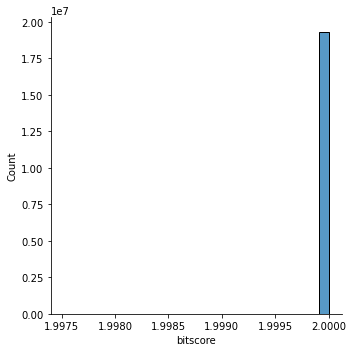

In [36]:
gather_results_query_found_hashes['bitscore'] = 1 - np.expm1(- m * n/2)
sns.displot(gather_results_query_found_hashes['bitscore'])

In [37]:
gather_results_query_found_hashes['bitscore'].describe()

count    1.934248e+07
mean     2.000000e+00
std      1.136495e-05
min      1.997521e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: bitscore, dtype: float64

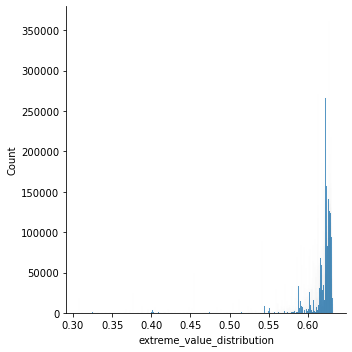

In [40]:
gather_results_query_found_hashes['extreme_value_distribution'] = -np.expm1(-np.exp(-gather_results_query_found_hashes['containment']))
sns.displot(gather_results_query_found_hashes['extreme_value_distribution'])

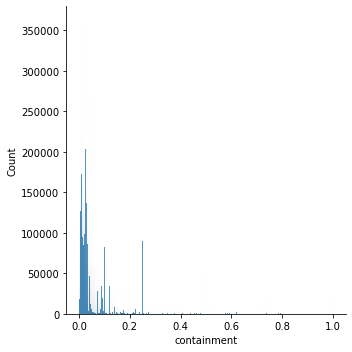

In [41]:
sns.displot(gather_results_query_found_hashes['containment'])

## Scale containment by number of hashes in the query and found sequence

### Create a pseudo-E-Value

A true E-value is:

$$
E = Kmn \exp(-\lambda S)
$$

Where $S$ is the score, $m$ and $n$ are the sequence search space (in alignment, these are lengths, but for k-mers, these are the number of k-mers per query and target), and $K$ and $\lambda$ are mystery scaling parameters that you need to simulate

CPU times: user 45 s, sys: 3.19 s, total: 48.2 s
Wall time: 48.3 s


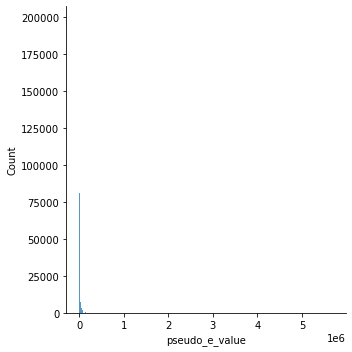

In [60]:
%%time

gather_results_query_found_hashes["pseudo_e_value"] = (
    gather_results_query_found_hashes.n_hashes_query
    * gather_results_query_found_hashes.n_hashes_found
    * np.exp(-gather_results_query_found_hashes["containment"])
)
sns.displot(gather_results_query_found_hashes["pseudo_e_value"])

In [61]:
gather_results_query_found_hashes["pseudo_e_value"].describe()

count    1.934248e+07
mean     1.661311e+04
std      6.369122e+04
min      5.668399e+00
25%      3.558515e+03
50%      7.631291e+03
75%      1.653108e+04
max      5.692463e+06
Name: pseudo_e_value, dtype: float64

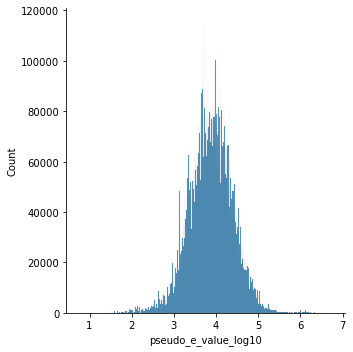

In [62]:
gather_results_query_found_hashes["pseudo_e_value_log10"] = np.log10(gather_results_query_found_hashes["pseudo_e_value"])
sns.displot(gather_results_query_found_hashes["pseudo_e_value_log10"])

In [63]:
gather_results_query_found_hashes["pseudo_e_value_log10"].describe()

count    1.934248e+07
mean     3.876606e+00
std      5.190933e-01
min      7.534604e-01
25%      3.551269e+00
50%      3.882598e+00
75%      4.218301e+00
max      6.755300e+00
Name: pseudo_e_value_log10, dtype: float64

## Write new dataframe to a file!!

In [67]:
parquet = os.path.join(
    outdir, "botryllus_gather_mouse_human_results_with_e_values.parquet"
)
gather_results_query_found_hashes.to_parquet(parquet)

# Spot-check TTN 

In [64]:
ttn = gather_results_query_found_hashes.query('symbol == "TTN"')
print(ttn.shape)
ttn.head()

(29844, 25)


,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,...,genomic_coord,all_homologs_found,transcript_id,n_hashes_query,n_hashes_found,bitscore,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10
14,9,HKCDICWKTFSRNSSLKLHMQIHD,pppphphpphppppphphphphpp,9725064853951588524,g10767.t1 frame:1,26237,SRTSLTIENANRNDSGKYTLTIQN,ENST00000342992.10 gene_id=ENSG00000155657.28;...,4,20,...,Chr2:178525989-178807423(-),False,ENST00000342992.10,85,6568,2.0,0.632009,5.454372e-10,558110.025880,5.746720
15,10,KCDICWKTFSRNSSLKLHMQIHDG,ppphphpphppppphphphphpph,73265585618797059,g10767.t1 frame:1,26238,RTSLTIENANRNDSGKYTLTIQNV,ENST00000342992.10 gene_id=ENSG00000155657.28;...,4,20,...,Chr2:178525989-178807423(-),False,ENST00000342992.10,85,6568,2.0,0.632009,5.454372e-10,558110.025880,5.746720
16,11,CDICWKTFSRNSSLKLHMQIHDGV,pphphpphppppphphphphpphh,3206271592278775523,g10767.t1 frame:1,26239,TSLTIENANRNDSGKYTLTIQNVL,ENST00000342992.10 gene_id=ENSG00000155657.28;...,4,20,...,Chr2:178525989-178807423(-),False,ENST00000342992.10,85,6568,2.0,0.632009,5.454372e-10,558110.025880,5.746720
17,12,DICWKTFSRNSSLKLHMQIHDGVK,phphpphppppphphphphpphhp,17414549284328662430,g10767.t1 frame:1,26240,SLTIENANRNDSGKYTLTIQNVLS,ENST00000342992.10 gene_id=ENSG00000155657.28;...,4,20,...,Chr2:178525989-178807423(-),False,ENST00000342992.10,85,6568,2.0,0.632009,5.454372e-10,558110.025880,5.746720
18,9,HKCDICWKTFSRNSSLKLHMQIHD,pppphphpphppppphphphphpp,9725064853951588524,g10767.t1 frame:1,19740,SRTSLTIENANRNDSGKYTLTIQN,ENST00000460472.6 gene_id=ENSG00000155657.28;t...,4,20,...,Chr2:178525989-178807423(-),False,ENST00000460472.6,85,5337,2.0,0.631983,8.260696e-10,453475.031849,5.656553


### Remove columns specific to kmers to explore scores for now
As if we had only run `sourmash gather`

In [65]:
kmer_cols = ('i_query', 'kmer_query', 'kmer_hp', 'hashval', 'i_found', 'kmer_found', 'found_i')
non_kmer_cols = [x for x in ttn.columns if x not in kmer_cols]

ttn_gather = ttn[non_kmer_cols].drop_duplicates().sort_values('intersect_bp', ascending=False)
print(ttn_gather.shape)
ttn_gather.head()

(3157, 18)


,name_query,name_found,n_kmers,intersect_bp,containment,symbol,species,homolog_group,genomic_coord,all_homologs_found,transcript_id,n_hashes_query,n_hashes_found,bitscore,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10
1700,g623.t1 frame:3,ENST00000342992.10 gene_id=ENSG00000155657.28;...,422,2110,0.000609,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342992.10,191,6568,2.0,0.631897,4.854677e-10,1.253724e+06,6.098202
2544,g623.t1 frame:3,ENST00000589042.5 gene_id=ENSG00000155657.28;t...,422,2110,0.000574,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000589042.5,191,6963,2.0,0.631909,4.319504e-10,1.329169e+06,6.123580
3388,g623.t1 frame:3,ENST00000342175.11 gene_id=ENSG00000155657.28;...,422,2110,0.000744,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342175.11,191,5378,2.0,0.631847,7.240775e-10,1.026434e+06,6.011331
3810,g623.t1 frame:3,ENST00000359218.10 gene_id=ENSG00000155657.28;...,422,2110,0.000746,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000359218.10,191,5365,2.0,0.631846,7.275908e-10,1.023951e+06,6.010279
2122,g623.t1 frame:3,ENST00000460472.6 gene_id=ENSG00000155657.28;t...,422,2110,0.000749,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000460472.6,191,5337,2.0,0.631845,7.352452e-10,1.018603e+06,6.008005


In [66]:
ttn_gather.tail()

,name_query,name_found,n_kmers,intersect_bp,containment,symbol,species,homolog_group,genomic_coord,all_homologs_found,transcript_id,n_hashes_query,n_hashes_found,bitscore,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10
25,g29054.t1 frame:1,ENST00000342992.10 gene_id=ENSG00000155657.28;...,2,10,0.000305,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342992.10,95,6568,2.0,0.632009,4.880228e-10,623770.028925,5.795025
10,g26625.t1 frame:1,ENST00000359218.10 gene_id=ENSG00000155657.28;...,2,10,0.000373,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000359218.10,21,5365,2.0,0.631983,3.308806e-09,112623.007828,5.051627
8,g26625.t1 frame:1,ENST00000342175.11 gene_id=ENSG00000155657.28;...,2,10,0.000372,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342175.11,21,5378,2.0,0.631984,3.292828e-09,112896.007809,5.052679
6,g26625.t1 frame:1,ENST00000591111.5 gene_id=ENSG00000155657.28;t...,2,10,0.000296,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000591111.5,21,6760,2.0,0.632012,2.084094e-09,141918.006212,5.152038
8,g20661.t1 frame:1,ENST00000342175.11 gene_id=ENSG00000155657.28;...,2,10,0.000372,TTN,human,TTN---Ttn,Chr2:178525989-178807423(-),False,ENST00000342175.11,38,5378,2.0,0.631984,1.819721e-09,204288.014130,5.310243


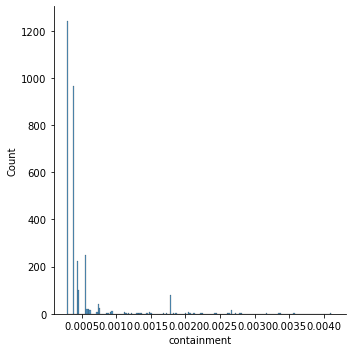

In [55]:
sns.displot(ttn_gather.containment)

In [1]:
sns.displot(ttn_gather.pseudo_e_value_log10)

NameError: name 'sns' is not defined

In [ ]:
ttn_gather.

In [46]:
ttn_hit_counts = ttn.name_query.value_counts()
ttn_hit_counts

g623.t1 frame:3      2532
g11790.t1 frame:3     876
g69.t1 frame:1        783
g35204.t1 frame:1     657
g632.t1 frame:1       636
                     ... 
g7464.t1 frame:1        2
g2811.t1 frame:2        2
g29114.t1 frame:1       2
g9677.t1 frame:1        2
g15951.t1 frame:1       2
Name: name_query, Length: 628, dtype: int64

In [48]:
ttn_top_hits = ttn_hit_counts[ttn_hit_counts > 500]
ttn_top_hits

g623.t1 frame:3      2532
g11790.t1 frame:3     876
g69.t1 frame:1        783
g35204.t1 frame:1     657
g632.t1 frame:1       636
g34387.t1 frame:1     627
g18528.t1 frame:1     567
g35447.t1 frame:1     553
Name: name_query, dtype: int64

In [50]:
ttn.query('name_query == "g623.t1 frame:3"')

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,...,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id,n_hashes_query,n_hashes_found,bitscore,extreme_value_distribution
1700,99,AADGGSPITGYHVERLDKHTGRWS,hhphhphhphhphpphpppphphp,3368047471689534604,g623.t1 frame:3,31117,VADVPDPPRGVKVSDVSRDSVNLT,ENST00000342992.10 gene_id=ENSG00000155657.28;...,422,2110,...,human,22,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342992.10,191,6568,2.0,0.631897
1701,99,AADGGSPITGYHVERLDKHTGRWS,hhphhphhphhphpphpppphphp,3368047471689534604,g623.t1 frame:3,31117,VADVPDPPRGVKVSDVSRDSVNLT,ENST00000342992.10 gene_id=ENSG00000155657.28;...,422,2110,...,human,22,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342992.10,191,6568,2.0,0.631897
1702,99,AADGGSPITGYHVERLDKHTGRWS,hhphhphhphhphpphpppphphp,3368047471689534604,g623.t1 frame:3,31117,VADVPDPPRGVKVSDVSRDSVNLT,ENST00000342992.10 gene_id=ENSG00000155657.28;...,422,2110,...,human,22,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342992.10,191,6568,2.0,0.631897
1703,99,AADGGSPITGYHVERLDKHTGRWS,hhphhphhphhphpphpppphphp,3368047471689534604,g623.t1 frame:3,31117,VADVPDPPRGVKVSDVSRDSVNLT,ENST00000342992.10 gene_id=ENSG00000155657.28;...,422,2110,...,human,22,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342992.10,191,6568,2.0,0.631897
1704,99,AADGGSPITGYHVERLDKHTGRWS,hhphhphhphhphpphpppphphp,16690911922473723528,g623.t1 frame:3,31117,VADVPDPPRGVKVSDVSRDSVNLT,ENST00000342992.10 gene_id=ENSG00000155657.28;...,422,2110,...,human,22,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000342992.10,191,6568,2.0,0.631897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,867,VVAKEMVEVPGPPSNPRVVDSTSR,hhhpphhphhhhhpphphhppppp,10596742494196135553,g623.t1 frame:3,12115,VVAKDPIEPPGPPTNFRVVDTTKH,ENST00000359218.10 gene_id=ENSG00000155657.28;...,422,2110,...,human,27,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000359218.10,191,5365,2.0,0.631846
4228,867,VVAKEMVEVPGPPSNPRVVDSTSR,hhhpphhphhhhhpphphhppppp,14832388870317579030,g623.t1 frame:3,12115,VVAKDPIEPPGPPTNFRVVDTTKH,ENST00000359218.10 gene_id=ENSG00000155657.28;...,422,2110,...,human,27,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000359218.10,191,5365,2.0,0.631846
4229,867,VVAKEMVEVPGPPSNPRVVDSTSR,hhhpphhphhhhhpphphhppppp,7440266603714710158,g623.t1 frame:3,12115,VVAKDPIEPPGPPTNFRVVDTTKH,ENST00000359218.10 gene_id=ENSG00000155657.28;...,422,2110,...,human,27,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000359218.10,191,5365,2.0,0.631846
4230,867,VVAKEMVEVPGPPSNPRVVDSTSR,hhhpphhphhhhhpphphhppppp,1887899284168062043,g623.t1 frame:3,12115,VVAKDPIEPPGPPTNFRVVDTTKH,ENST00000359218.10 gene_id=ENSG00000155657.28;...,422,2110,...,human,27,TTN---Ttn,Chr2:178525989-178807423(-),True,ENST00000359218.10,191,5365,2.0,0.631846


# Look at HLA

In [68]:
hla = gather_results_query_found_hashes.query('symbol == "HLA"')
print(hla.shape)
hla.head()

(1607, 25)


,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,...,genomic_coord,all_homologs_found,transcript_id,n_hashes_query,n_hashes_found,bitscore,extreme_value_distribution,containment_scaled,pseudo_e_value,pseudo_e_value_log10
0,101,LNASVEILSYFALWGFLRLAGMRI,hphphphhphhhhhhhhphhhhph,14727812379951326220,g24803.t1 frame:2,216,LKVSVSAVTLGLGLIIFSLGVISW,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,ENST00000418107.3,30,42,2.0,0.614609,0.000038,1201.406163,3.07969
1,102,NASVEILSYFALWGFLRLAGMRIT,phphphhphhhhhhhhphhhhphp,12122782715747205387,g24803.t1 frame:2,217,KVSVSAVTLGLGLIIFSLGVISWR,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,ENST00000418107.3,30,42,2.0,0.614609,0.000038,1201.406163,3.07969
2,103,ASVEILSYFALWGFLRLAGMRITC,hphphhphhhhhhhhphhhhphpp,731582254459325854,g24803.t1 frame:2,218,VSVSAVTLGLGLIIFSLGVISWRR,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,ENST00000418107.3,30,42,2.0,0.614609,0.000038,1201.406163,3.07969
3,104,SVEILSYFALWGFLRLAGMRITCF,phphhphhhhhhhhphhhhphpph,9470123982851188374,g24803.t1 frame:2,219,SVSAVTLGLGLIIFSLGVISWRRA,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,ENST00000418107.3,30,42,2.0,0.614609,0.000038,1201.406163,3.07969
4,105,VEILSYFALWGFLRLAGMRITCFL,hphhphhhhhhhhphhhhphpphh,1731407111791498839,g24803.t1 frame:2,220,VSAVTLGLGLIIFSLGVISWRRAG,ENST00000418107.3 gene_id=ENSG00000242574.9;tr...,6,30,...,None,None,ENST00000418107.3,30,42,2.0,0.614609,0.000038,1201.406163,3.07969


In [69]:
hla.pseudo_e_value_log10.describe()

count    1607.000000
mean        3.456208
std         0.348924
min         2.490148
25%         3.190548
50%         3.514182
75%         3.708234
max         4.292584
Name: pseudo_e_value_log10, dtype: float64

In [ ]:
hla